<a href="https://colab.research.google.com/github/enakai00/rl_book_solutions/blob/master/Chapter08/Exercise_8_2_8_4_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 8.2 - 8.4 : Solution

In [0]:
import numpy as np
from numpy import random
from pandas import DataFrame

In [0]:
maze_img = '''
###########
#         #
#         #
#         #
# #########
#         #
#         #
###########
'''
def get_track(track_img):
  x_max = max(map(len, track_img.split('\n')))
  track = []
  for line in track_img.split('\n'):
    if line == '':
      continue 
    line += ' ' * x_max
    track.append(list(line)[:x_max])

  return np.array(track)

In [0]:
class Agent:
  def __init__(self, x=1, y=3, shortcut=True, q_plus=True, alternate=False):
    self.path = []
    self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    self.shortcut = shortcut
    self.q_plus = q_plus
    self.alternate = alternate
    self.q = {}
    self.model = {}
    self.rewards = [0]
    self.restart(x, y)
    self.maze = get_track(maze_img)

  def restart(self, x=4, y=6):
    self.x, self.y = x, y
    self.path = []

  def get_state(self):
    return self.x, self.y

  def show_path(self):
    result = self.maze.copy()
    for c, (x, y, a) in enumerate(self.path):
      result[y][x] = str(c)[-1]
    result[1][9] = 'G'
    return result     

  def add_rewards(self, r=0):
    self.rewards.append(self.rewards[-1]+r)

  def move(self, action):
    self.path.append((self.x, self.y, action))
    if len(self.rewards) == 3000 and self.shortcut:  # Open shortcut
      self.maze[4][9] = ' '
    sa = "{:02},{:02}:{:02}".format(self.x, self.y, action)
    vx, vy = self.actions[action]
    if self.maze[self.y+vy][self.x+vx] == '#':
      vx, vy = 0, 0
    self.x += vx
    self.y += vy
    if (self.x, self.y) == (9, 1): # Finish
      self.model[sa] = (1, self.x, self.y, len(self.rewards))
      return True
    self.model[sa] = (0, self.x, self.y, len(self.rewards))
    return False

In [0]:
def get_action(agent, epsilon):
  if random.random() < epsilon:
    a = random.randint(0, 4)
  else:
    a = optimal_action(agent)
  return a

def optimal_action(agent):
  kappa = 0.01
  x, y = agent.get_state()
  q_vals = []
  for a in range(4):
    sa = "{:02},{:02}:{:02}".format(x, y, a)
    if sa not in agent.q.keys():
      agent.q[sa] = 0
    q_val = agent.q[sa]

    if agent.alternate:
      if sa not in agent.model.keys():
        t = 0
      else:
        _, _, _, t = agent.model[sa]
      q_val += kappa * np.sqrt(len(agent.rewards)-t)

    q_vals.append(q_val)
  q_max = np.max(q_vals)
  candidates = []
  for i, q in enumerate(q_vals):
    if q == q_max:
      candidates.append(i)
  a = random.choice(candidates)
  return a

def update_q(agent, sa1, r, planning_steps):
  alpha = 0.1
  gamma = 0.95
  kappa = 0.01
  if sa1 not in agent.q.keys():
    agent.q[sa1] = 0

  x, y = agent.get_state()
  a = optimal_action(agent)
  sa2 = "{:02},{:02}:{:02}".format(x, y, a)
  if sa2 not in agent.q.keys():
    agent.q[sa2] = 0
  agent.q[sa1] += alpha * (r + gamma * agent.q[sa2] - agent.q[sa1])

  if agent.q_plus:
    kappa = 0.01
  else:
    kappa = 0
  for _ in range(planning_steps):
    if agent.q_plus:
      x = random.randint(1, len(agent.maze[0])-1)
      y = random.randint(1, len(agent.maze)-1)
      a = random.randint(4)
      sa1 = "{:02},{:02}:{:02}".format(x, y, a)
      if sa1 not in agent.model.keys():
        agent.model[sa1] = (0, x, y, 0)
      r, x, y, t = agent.model[sa1]
      r += kappa * np.sqrt(len(agent.rewards)-t)
    else:
      sa1 = np.random.choice(list(agent.model.keys()))
      r, x, y, t = agent.model[sa1]

    _x, _y = agent.x, agent.y
    agent.x, agent.y = x, y
    a = optimal_action(agent)
    agent.x, agent.y = _x, _y
    sa2 = "{:02},{:02}:{:02}".format(x, y, a)

    if sa1 not in agent.q.keys():
      agent.q[sa1] = 0
    if sa2 not in agent.q.keys():
       agent.q[sa2] = 0
    agent.q[sa1] += alpha * (r + gamma * agent.q[sa2] - agent.q[sa1])


def trial(agent, epsilon=0.1, planning_steps=5):
  agent.restart()
  x, y = agent.get_state()
  
  while True:
    x, y = agent.get_state()
    a = get_action(agent, epsilon)
    sa1 = "{:02},{:02}:{:02}".format(x, y, a)
    finished = agent.move(a)

    if finished:
      update_q(agent, sa1, 1, planning_steps)
      agent.add_rewards(1)
      break
    else:
      update_q(agent, sa1, 0, planning_steps)
      agent.add_rewards(0)
      

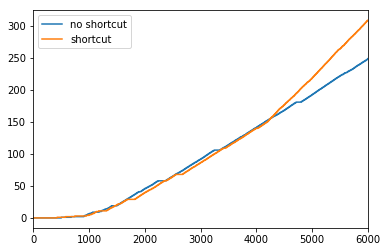

In [5]:
df = DataFrame()

agent = Agent(shortcut=False, q_plus=True)
while True:
  trial(agent, planning_steps=40)
  if len(agent.rewards) > 6001:
    break
df['no shortcut'] = agent.rewards[:6001]

agent = Agent(shortcut=True, q_plus=True)
while True:
  trial(agent, planning_steps=40)
  if len(agent.rewards) > 6001:
    break
df['shortcut'] = agent.rewards[:6001]

df.plot()

In [6]:
trial(agent, epsilon=0, planning_steps=0)
print(len(agent.path))
for line in agent.show_path():
  print (''.join(line))

10
###########
#        G#
#        9#
#        8#
# #######7#
#    23456#
#   01    #
###########


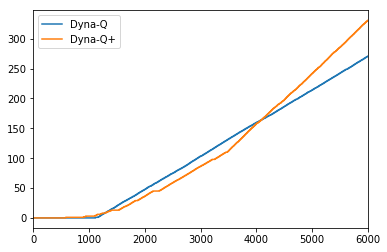

In [7]:
df = DataFrame()

agent = Agent(shortcut=True, q_plus=False)
while True:
  trial(agent, planning_steps=40)
  if len(agent.rewards) > 6001:
    break
df['Dyna-Q'] = agent.rewards[:6001]

agent = Agent(shortcut=True, q_plus=True)
while True:
  trial(agent, planning_steps=40)
  if len(agent.rewards) > 6001:
    break
df['Dyna-Q+'] = agent.rewards[:6001]

df.plot()

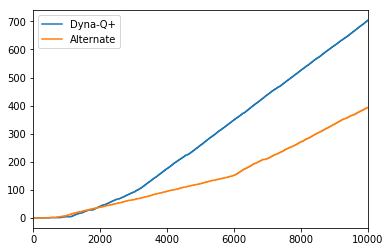

In [8]:
df = DataFrame()

agent = Agent(shortcut=True, q_plus=True)
while True:
  trial(agent, planning_steps=40)
  if len(agent.rewards) > 10001:
    break
df['Dyna-Q+'] = agent.rewards[:10001]

agent = Agent(shortcut=True, q_plus=False, alternate=True)
while True:
  trial(agent, planning_steps=40)
  if len(agent.rewards) > 10001:
    break
df['Alternate'] = agent.rewards[:10001]

df.plot()